In [5]:
import os
import pandas as pd
import geopandas as gpd
import cdsapi
from datetime import datetime, timedelta
import xarray as xr
import netCDF4
import zipfile
import shutil
import matplotlib.pyplot as plt

# === SETTINGS ===
outage_file  = "data_collection_by_hollis/correlated_outage/extreme_outage_events.csv"
weather_dir  = "data_collection_by_hollis/correlated_outage/weather_output"
os.makedirs(weather_dir , exist_ok=True)

# Load outage events
df = pd.read_csv(outage_file)

In [6]:
df = df.drop(columns=[
    col for col in df.columns if any(x in col for x in ["STATEFP", "COUNTYFP", "STATE_NAME", "NAME", "lat", "lon"])
])

# Load U.S. county shapefile from Census
shapefile_path = "data_collection_by_hollis/shapefiles/cb_2020_us_county_5m.zip"
counties = gpd.read_file(shapefile_path)
counties["lat"] = counties.geometry.centroid.y
counties["lon"] = counties.geometry.centroid.x

# Re-project to a U.S.-appropriate planar CRS
counties = counties.to_crs(epsg=5070)
counties["county_lat"] = counties.geometry.centroid.to_crs(epsg=4326).y
counties["county_lon"] = counties.geometry.centroid.to_crs(epsg=4326).x

# Rename to match clean merge keys
counties = counties.rename(columns={
    "NAME": "county",
    "STATE_NAME": "state"
})

# Merge on lowercase standardized fields
df = df.merge(
    counties[["state", "county", "county_lat", "county_lon"]],
    on=["state", "county"],
    how="left"
)

counties[['state', 'county', 'county_lat', 'county_lon']].to_csv("county_centroids.csv", index=False)


C:\Users\holli\AppData\Local\Temp\ipykernel_37424\836355668.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties["lat"] = counties.geometry.centroid.y
C:\Users\holli\AppData\Local\Temp\ipykernel_37424\836355668.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counties["lon"] = counties.geometry.centroid.x


In [39]:
def unzip_and_collect(zip_path):
    folder = os.path.dirname(zip_path)
    if not zipfile.is_zipfile(zip_path):
        return [zip_path]  # already .nc or uncompressed

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(folder)
        extracted = [os.path.join(folder, f) for f in zip_ref.namelist()]
    return [f for f in extracted if f.endswith(".nc") or f.endswith(".grib")]

In [ ]:
def clean_downloaded_nc_files(keep_path, extra_paths):
    for path in extra_paths:
        if os.path.exists(path) and path != keep_path:
            try:
                os.remove(path)
                print(f"🗑️ Deleted extra file: {path}")
            except Exception as e:
                print(f"⚠️ Could not delete: {path}\n   {e}")


In [ ]:
def download_hourly_weather(lat, lon, datetime_str, event_index, save_folder):

    client = cdsapi.Client()
    target_datetime = pd.to_datetime(datetime_str)
    start_datetime = target_datetime - timedelta(hours=47)

    area = [round(float(lat)+0.1, 4), round(float(lon)-0.1, 4),
            round(float(lat)-0.1, 4), round(float(lon)+0.1, 4)]

    out_file = os.path.join(
        save_folder,
        f"event_{event_index}_{target_datetime.strftime('%Y-%m-%d_%H-%M')}.nc"
    )
    temp_file = out_file.replace(".nc", "_raw.nc")  # Always save to a "raw" temp file

    if os.path.exists(out_file):
        print(f"✅ Already exists: {out_file}")
        return out_file

    print(f"\n📂  Requesting: {out_file}")
    print(f" → Period: {start_datetime} to {target_datetime}, Area: {area}")

    try:
        client.retrieve(
            'reanalysis-era5-single-levels',
            {
                'product_type': 'reanalysis',
                'format': 'netcdf',
                'variable': [
                    '2m_temperature',
                    # '2m_dewpoint_temperature',
                    # 'surface_pressure',
                    # '10m_u_component_of_wind',
                    # '10m_v_component_of_wind',
                    # 'instantaneous_10m_wind_gust',
                    'total_precipitation',
                    # 'snowfall',
                    # 'total_column_rain_water',
                    # 'surface_net_solar_radiation',
                    # 'surface_latent_heat_flux',
                    # 'boundary_layer_height',
                ],
                # 'format': 'grib',
                'date': f"{start_datetime.date()}/{target_datetime.date()}",
                'time': [f"{h:02}:00" for h in range(24)],
                'area': area,
            },
            temp_file
        )

        # Detect if it's actually a ZIP file by checking the first few bytes
        with open(temp_file, 'rb') as f:
            magic_number = f.read(4)

        if magic_number == b'PK\x03\x04':
            # It's actually a ZIP file
            with zipfile.ZipFile(temp_file, 'r') as zip_ref:
                zip_ref.extractall(save_folder)
                nc_files = [os.path.join(save_folder, name) for name in zip_ref.namelist() if name.endswith(".nc")]

            if not nc_files:
                print("❌ No .nc file inside the zip.")
                return None

            os.rename(nc_files[0], out_file)
            print(f"✅ Extracted and renamed to: {out_file}")
            for f in nc_files[1:]:
                os.remove(f)
            os.remove(temp_file)

        else:
            # It's a real NetCDF file (rare for multi-variable requests, but may happen)
            os.rename(temp_file, out_file)
            print(f"✅ Downloaded NetCDF saved as: {out_file}")

        return out_file

    except Exception as e:
        print(f"❌ Download or processing failed for event {event_index}\n   {e}")
        return None

In [62]:
for i, row in df.iterrows():
    try:
        if pd.isnull(row['start_time']):
            continue
        date_str = pd.to_datetime(row['start_time']).strftime('%Y-%m-%d %H:%M')
        lat, lon = row['county_lat'], row['county_lon']
        download_hourly_weather(lat, lon, date_str, i, 'data_collection_by_hollis/correlated_outage/weather_output')
    except Exception as e:
        print(f"❌ Failed event {i} ({row['county']}): {e}")
    break


2025-04-23 19:36:43,867 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-23 19:36:43,869 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.



📂  Requesting: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_09-30.nc
 → Period: 2014-11-22 10:30:00 to 2014-11-24 09:30:00, Area: [36.4686, -90.5171, 36.2686, -90.3171]


2025-04-23 19:36:44,955 INFO Request ID is 22f6160c-c5d7-4d10-8ee5-defe48b802f9
2025-04-23 19:36:45,223 INFO status has been updated to accepted
2025-04-23 19:36:54,425 INFO status has been updated to running
2025-04-23 19:37:07,629 INFO status has been updated to successful


4d7efad7fad8ec0c4d5c5f4cbb2f9d6e.nc:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

✅ Downloaded NetCDF saved as: data_collection_by_hollis/correlated_outage/weather_output\event_0_2014-11-24_09-30.nc


b'\x89HDF\r\n\x1a\n\x02\x08\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xffed\x00\x00\x00\x00\x00\x000\x00\x00\x00\x00\x00\x00\x00\xc5H%\xb5OHDR\x02\r\xb7\x02\x02"\x00\x00\x00\x00\x00\x03\t\x00\x00\x00\x00\x00\x00\x00\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\n\x02\x00\x01\x00\x00\x00\x00\x10\x10\x00\x00\x00\x00\xff\x03\x00\x00\x00\x00\x00\x00c\x00\x00\x00\x00\x00\x00\x00\x0c%\x00\x00\x00\x00\x03\x00\x0c\x00\x08\x00\x04\x00\x00GRIB_centre\x00\x13\x00\x00\x00\x04\x00\x00\x00\x02\x00\x00\x00ecmf\x0c^\x00\x00\x01\x00\x03\x00\x17\x00\x08\x00\x04\x00\x00GRIB_centreDescription\x00\x13\x00\x00\x002\x00\x00\x00\x02\x00\x00\x00European Centre for Medium-Range Weather Forecasts\x0c@\x00\x00\x02\x00\x03\x00\x0f\x00\x0c\x00\x14\x00\x00GRIB_subCentre\x00\x10'
data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_09-30.nc size: 25701 bytes
1.7.2
{'netcdf4': <NetCDF4BackendEntrypoint>
  Open netCDF (

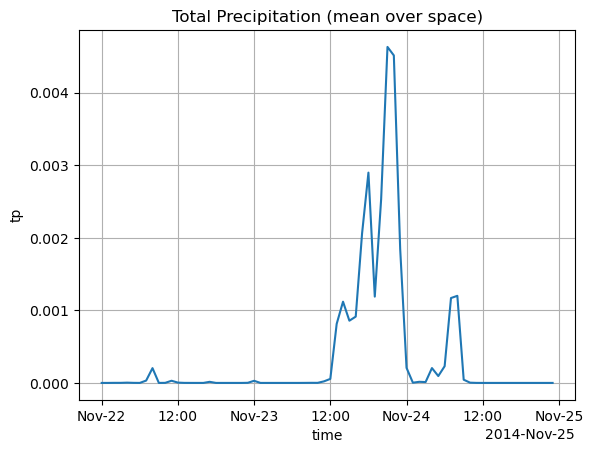

In [64]:
import matplotlib.pyplot as plt

file = "data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_09-30.nc"
# file = "data_collection_by_hollis/correlated_outage/weather_output/event_0_2014-11-24_00-00_combined.nc"
xr.open_dataset(file, engine="h5netcdf")

with open(file, "rb") as f:
    head = f.read(512)
    print(head[:300])

file_path = file
print(f"{file_path} size: {os.path.getsize(file_path)} bytes")

print(netCDF4.__version__)
print(xr.backends.list_engines())

ds = xr.open_dataset(
    file,
    engine="netcdf4"
)

print(ds)

# Dictionary of variable names and titles
plot_vars = {
    't2m': '2m Temperature',
    'd2m': '2m Dew Point Temperature',
    'sp': 'Surface Pressure',
    'u10': '10m U Wind',
    'v10': '10m V Wind',
    'i10fg': 'Instantaneous 10m Wind Gust',
    'tcrw': 'Total Column Rain Water',
    'blh': 'Boundary Layer Height',
    'tp': 'Total Precipitation',
    'sf': 'Snowfall',
    'slhf': 'Surface Latent Heat Flux',
    'avg_snswrf': 'Average Net Short-Wave Radiation Flux'
}

for var, title in plot_vars.items():
    if var in ds:
        plt.figure()
        ds[var].mean(dim=['latitude', 'longitude']).plot()
        plt.title(f"{title} (mean over space)")
        plt.grid(True)
    else:
        print(f"⚠️ Variable '{var}' not found in dataset.")
ds.close()
